**Objective:** to gain practical skills in building and training neural networks using PyTorch tools.

**Topics covered:** augmentation, search by hyperparameters, transfer learning with fine-tuning.


**Data:** Open Images Dataset V6 + Extensions ([source](https://storage.googleapis.com/openimages/web/index.html)).

## 1. Setup

The images that we have already downloaded from Open images are stored on Google Drive, so we need to connect it. If the images are stored on a disk, we do not need to do this step.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To configure the hyperparameters of the model, we will use the Ray Tune(information about which can be viewed at the links to [the paper](https://arxiv.org/abs/1807.05118) and [the site](https://docs.ray.io/en/latest/tune/index.html)). But first we need to install it, either in a working virtual environment, or, as in our case, through the current Colab notebook.

In [ ]:
!pip install -q ray[default]
!pip install -q ray[tune]

     |████████████████████████████████| 51.6MB 58kB/s 
     |████████████████████████████████| 10.1MB 45.3MB/s 
     |████████████████████████████████| 3.1MB 47.4MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
     |████████████████████████████████| 133kB 59.9MB/s 
     |████████████████████████████████| 1.3MB 44.4MB/s 
     |████████████████████████████████| 204kB 59.9MB/s 
     |████████████████████████████████| 92kB 544kB/s 
     |████████████████████████████████| 296kB 50.3MB/s 
     |████████████████████████████████| 143kB 52.6MB/s 
     |████████████████████████████████| 133kB 7.5MB/s 


In [ ]:
import os
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

To build neural network models of image classification, we will use the PyTorch tools, namely TORCH and TORCHVISION, which we can access by importing the corresponding modules.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
from torchvision import models

In [ ]:
from ray import tune
from ray.tune import JupyterNotebookReporter

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


## 2. Image exploration for classification

For the classification task, we selected two classes "rabbit" and "squirrel" and downloaded the corresponding datasets from the Open Images, changing the storage format to the following:

```
image_store_dir/
    train/
        rabbit/
            image1.jpg
            image2.jpg
            ...
        squirrel/
            image3.jpg
            ...
    validation/
        ...
    test/
        ...
```

The "validation" and "test" directories are organized in the same way as the "train" directory. 

For our objective, we only need images that accurately contain rabbits or squirrels, as well as animals close to them or related to the same family, i.e. images with hares and with any representatives of squirrels (tree squirrels, chipmunks, prairie dogs, etc.). 

Since there aren't many images in our dataset, we manually checked whether they were correctly classified. As a result, they were deleted: 

1. images that do not have representatives of the selected classes, for example, instead of them there are guinea pigs, chinchillas and kangaroos;
2. ambiguous images, for example, with people in rabbit costumes;
3. those that contain both squirrels and rabbits. 

About ten of the images had mixed-up labels, which meant that the squirrels were labeled as rabbits and vice versa. We just moved them to the correct classes.

After all these transformations, we got a dataset with imbalanced classes, which has more training data of the "squirrel" class (almost 2 times), and validation and test data of the "rabbit" one. So we will use some of the validation and test images of rabbits for training so that these first two groups are equal for these two classes, but only those images that are not similar to the remaining ones.

As a result, we have 864 images of rabbits and 1749 images of squirrels for training, 41 images of each class for validation, and 84 images for testing.

Let's look at some of the training images we have. 

To load them, there is a ready-made tool ImageFolder in the TORCHVISION, but we will override the find_classes function in it so that the positive classes become "rabbit". In fact, we will simply copy this function from the touchvision.datasets.folder module, and we will set reverse=True in the sorted method.

In [ ]:
class ReverseImageFolder(ImageFolder):
    """Image loader from the directory with classes in reverse alphabetical order."""
    def __init__(self, img_dir, image_transform=None):
        super().__init__(root=img_dir, transform=image_transform)
            
    def find_classes(self, directory):
        """Finds the class folders in a dataset."""
        classes = sorted((entry.name for entry in os.scandir(directory) if entry.is_dir()), 
                         reverse=True)
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [ ]:
# Set base parameters for transforming
torch.manual_seed(0)
interp_mode = TF.InterpolationMode.NEAREST

# Set parameters for loading
IMAGE_SIZE = (180, 180)

In [ ]:
# Specify directories where all the project data is stored
project_dir = '/content/drive/MyDrive/Colab_Notebooks/Rabbit_Squirrel_Project'
image_store_dir = os.path.join(project_dir, 'Images_by_class')

train_dir = os.path.join(image_store_dir, 'train')
val_dir = os.path.join(image_store_dir, 'validation')
test_dir = os.path.join(image_store_dir, 'test')

In [ ]:
# Load images for viewing
train_img_ds = ReverseImageFolder(train_dir,  
    image_transform=T.Resize(size=IMAGE_SIZE, interpolation=interp_mode))

In [ ]:
# Look at names of found classes and their labels
print(train_img_ds.classes)
print(train_img_ds.class_to_idx)

['squirrel', 'rabbit']
{'squirrel': 0, 'rabbit': 1}


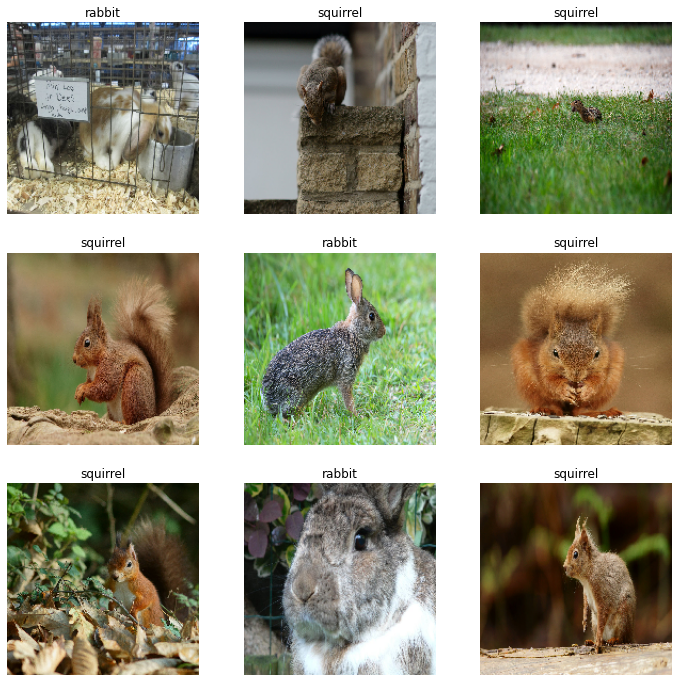

In [ ]:
# Show some images from the traininig dataset
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for i in range(9):
    idx = random.randint(1, len(train_img_ds))
    image, label = train_img_ds[idx]
    axs[i].imshow(image)
    axs[i].set_title(train_img_ds.classes[label])
    axs[i].axis('off')

## 3. Working with neural network models

### 3.1. Definition of model architecture and functions for a process of its training

Our task is to classify images, so we will build a convolutional neural network (CNN), which will be simple because our objective is not to create a high-accuracy model, although we will try to improve it later.

In [ ]:
class ImageClassCNN(nn.Module):
    """Convolutional neural network for image classification."""
    def __init__(self):
        super().__init__()
        self.conv_relu_maxpool = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.lin_relu = nn.Sequential(
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.conv_relu_maxpool(x)
        x = self.flatten(x)
        out = self.lin_relu(x)
        return out

To organize the training process, we will define several functions that will help us implement training, evaluate and save its results, evaluate its results and, if necessary, check whether the indicators have improved.

In [ ]:
def train_model(nn_model, train_dataloader, loss_fn, optimizer, metric_fn=None, 
                device_used=None, train_batch_norm_dropout_layers=True):
    """Passes a training step in one epoch."""
    total_losses = 0
    total_metrics = 0
    metric_name = 'None'
    num_batches = len(train_dataloader)
    device = device_used if device_used else torch.device('cpu')

    if train_batch_norm_dropout_layers:
        nn_model.train()
    else:
        for layer in nn_model.modules():
            if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.Dropout):
                layer.eval()
            else:
                layer.train()

    for X_batch, y_batch in train_dataloader:
        y_batch = y_batch.unsqueeze(1).to(torch.float)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Сompute prediction losses
        y_batch_pred = nn_model(X_batch)
        loss_batch_mean = loss_fn(y_batch_pred, y_batch)

        # Optimize model parameters
        optimizer.zero_grad()
        loss_batch_mean.backward()
        optimizer.step()
    
        total_losses += loss_batch_mean.item()
        if metric_fn:
            metric_batch_mean = metric_fn(y_batch, y_batch_pred)
            total_metrics += metric_batch_mean
            metric_name = metric_fn.__name__
    
    avg_loss, avg_metric  = [tm / num_batches for tm in [total_losses, total_metrics]]
     
    print("Train -- loss: {0:.4f}, {1}: {2:.4f}".format(
        avg_loss, metric_name, avg_metric))
    
    return avg_loss, avg_metric

In [ ]:
def evaluate_model(nn_model, val_dataloader, loss_fn, metric_fn=None, 
                   device_used=None):
    """Passes a validation step in one epoch."""
    total_losses = 0
    total_metrics = 0
    metric_name = 'None'
    num_batches = len(val_dataloader)
    device = device_used if device_used else torch.device('cpu')

    nn_model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            y_batch = y_batch.unsqueeze(1).to(torch.float)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Compute prediction losses
            y_batch_pred = nn_model(X_batch)
            loss_batch_mean = loss_fn(y_batch_pred, y_batch)

            total_losses += loss_batch_mean.item()
            if metric_fn:
                metric_batch_mean = metric_fn(y_batch, y_batch_pred)
                total_metrics += metric_batch_mean
                metric_name = metric_fn.__name__
    
    avg_loss, avg_metric = [tm / num_batches for tm in [total_losses, total_metrics]]
    print("Val -- loss: {0:.4f}, {1}: {2:.4f}".format(
        avg_loss, metric_name, avg_metric))
    
    return avg_loss, avg_metric

As an additional metric for evaluating our model, we will define a binary_accuracy function. And since the model does not transform the output data using sigmoid, we will add this transformation directly to the function for the correct comparison of targets and predictions.

In [ ]:
@torch.no_grad()
def binary_accuracy(y_true_tensor, y_pred_tensor):
    """Computes the frequency of matching predictions with binary labels
    and returns the number."""
    y_pred_round = torch.round(torch.sigmoid(y_pred_tensor))
    binary_accuracy_mean = torch.mean(torch.eq(y_true_tensor, y_pred_round)
                                           .to(torch.float)).item()
    return binary_accuracy_mean

In [ ]:
def check_best_metric(current_metric_value, all_metric_values, maximization=True):
    """Checks whether the current value of monitored metric is the best."""
    metric_is_the_best = False
    
    if all_metric_values:
        if maximization and (current_metric_value > max(all_metric_values)):
            metric_is_the_best = True
        elif not maximization and (current_metric_value < min(all_metric_values)):
            metric_is_the_best = True
    else:
        metric_is_the_best=True
    
    return metric_is_the_best  

We will also include the ability to save a dictionary of the state of models with the best values of the metrics we monitor. *(When we talk about saving or loading model weights, we will mean the entire dictionary of states, not just the states of the weights.)*

In [ ]:
def save_model_weights(save_model_weights_dir, model_to_save, metric_name=''):
    """Saves weights of neural networks.
    
    Parameters:
    -----------
    save_model_weights_dir -- a directory for storing selected model weights
    model_to_save -- a model whose state dictionary we want to save
    metric_name (optional) -- a name of metric for a file name
    """
    metric_fname = '_'.join(['best', metric_name, 'weights.pt'])
    filepath = os.path.join(save_model_weights_dir, metric_fname)
    torch.save(model_to_save.state_dict(), filepath)

Now we will combine all the functions described above into one, with the help of which we will fit our model.

In [ ]:
def fit(nn_model, train_dataloader, loss_fn, optimizer, epochs, metric_fn=None, 
        greater_metric_is_better=True, val_dataloader=None, device=None,
        train_batch_norm_dropout_layers=True, num_epochs_wait_early_stopping=0, 
        save_best=None, save_model_weights_dir=None):
    """Trains a neural network model with the specified parameters.
    
    Parameters:
    -----------
    nn_model -- a neural network model
    train_dataloader -- a dataloader for a training dataset
    loss_fn -- a loss function for optimization
    optimizer -- a loss function optimizer
    epochs -- the number of training epochs
    metric_fn (optional) -- an additional metric for monitoring
    greater_metric_is_better -- specifies which metric values are considered 
        the best (minimum or maximum). Ignored if metric_fn is None
    val_dataloader (optional) -- a dataloader used for validation
    device -- the object returned by torch.device. If None, then the device is 
        torch.device('cpu')
    train_batch_norm_dropout_layers -- whether to train the BatchNorm2d and Dropout 
        layers during fine-tuning, for example. By default, True
    num_epochs_wait_early_stopping (optional) -- an early stopping is performed 
        when the number of epochs is reached without reducing validation losses. 
        If 0, then an early stopping is not performed. Ignored if val_dataloader is None
    save_best: {None, 'loss', 'both'} (optional) -- whether or not to save the model 
        with the best validation loss or with the best validation loss and the metric value. 
        Ignored if val_dataloader is None
    save_model_weights_dir (optional) -- a directory for saving model weights. Ignored 
        if save_best is None 

    Returns losses and metric values of training and validation for each epoch.
    """
    train_losses_by_epoch = []
    train_metrics_by_epoch = [] 
    val_losses_by_epoch = []
    val_metrics_by_epoch = [] 
    num_epochs_without_improv_vl = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}:")

        # Train a neural network model
        avg_train_loss, avg_train_metric = train_model(nn_model, train_dataloader, 
            loss_fn, optimizer, metric_fn, device, train_batch_norm_dropout_layers)
        train_losses_by_epoch.append(avg_train_loss)
        train_metrics_by_epoch.append(avg_train_metric)
        
        # Evaluate the trained model
        if val_dataloader:
            avg_val_loss, avg_val_metric = evaluate_model(nn_model, val_dataloader, 
                loss_fn, metric_fn, device)
            val_losses_by_epoch.append(avg_val_loss)
            val_metrics_by_epoch.append(avg_val_metric)
            
            # Enable saving weights with the best validation metric value
            if metric_fn and (save_best == 'both'):
                best_vmetric = check_best_metric(avg_val_metric, val_metrics_by_epoch[:-1], 
                                                 maximization=greater_metric_is_better) 
                if best_vmetric:
                    save_model_weights(save_model_weights_dir, nn_model, metric_name)
                    print(f"Saved the best validation {metric_name} weights!")

            # Enable monitoring of validation loss changes
            if num_epochs_wait_early_stopping or save_best:
                best_vloss = check_best_metric(avg_val_loss, val_losses_by_epoch[:-1], 
                                               maximization=False)

                if best_vloss:
                    num_epochs_without_improv_vl = 0
                    if (save_best == 'loss' or 'both') and save_model_weights_dir:
                        save_model_weights(save_model_weights_dir, nn_model, 'loss')
                        print("Saved the best validation loss weights!")
                else:
                    num_epochs_without_improv_vl += 1
                    if (num_epochs_wait_early_stopping and 
                    (num_epochs_wait_early_stopping == num_epochs_without_improv_vl)):
                        print("Early Stopping!")
                        break
             
        print("-" * 60)

    return (train_losses_by_epoch, train_metrics_by_epoch, 
            val_losses_by_epoch, val_metrics_by_epoch)

The results of the obtained loss and metric values can be visualized, both with the TensorBoard using a SummaryWriter class from torch.utils.tensorboard and with matplotlib tools. The first option also allows us to view the rendered graph of models and much more. To do this, we need to write the appropriate magic functions, with which the results will be displayed immediately in the notebook:

```
%load_ext tensorboard 
%tensorboard --logdir /path_to_logdir
```

Since we only want to look at the change in indicators, we will use the second option and create a function for this.

In [ ]:
def show_train_results(losses, metric_values=None, metric_name='', colors=('cadetblue', 'salmon')):
    """Visualizes training and validation loss and metric values.
    
    Parameters:
    -----------
    losses -- a tuple of training and validation lists of losses obtained 
        at the end of each epoch
    metric_values -- a tuple of training and validation lists of metric values obtained 
        at the end of each epoch
    metric_name -- a name of the metric used
    colors -- training and validation line colors
    """
    res_metrics = [losses]
    if metric_values:
        res_metrics.append(metric_values)
    ncols = len(res_metrics)

    fig, axs = plt.subplots(ncols=ncols, figsize=(14, 6))
    
    for i in range(0, ncols):
        ax, (param, val_param) = axs[i], res_metrics[i]

        optim_res_val_param = min(val_param)
        param_name = 'loss'

        if i != 0:
            optim_res_val_param = max(val_param)
            param_name = metric_name
        
        optim_epoch = val_param.index(optim_res_val_param) + 1
        result_range = range(1, len(param) + 1)
        labels = [f"Train {param_name}", f"Val {param_name}"]

        ax.plot(result_range, param, color=colors[0], label=labels[0])
        ax.plot(result_range, val_param, color=colors[1], label=labels[1])
        ax.legend(loc='upper left')
        ax.grid(alpha=0.6)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("{}".format(param_name.title()))
        title = ("Training and validation {0}\n(the best val {1}: {2:0.4f}, epoch: {3})"
                     .format(param_name, param_name, optim_res_val_param, optim_epoch))
        ax.set_title(title)

    plt.show()

### 3.2. Data transformation and model training

Before using dataset in our neural network model, we need to transform them so that the training goes better, namely: bring them to a single size and scale the values to the range [0, 1]. Let's call such transformations basic.

Now the size of the images is different and is set in the range [0, 255] (since the RGB color mode is used). We also have, as mentioned earlier, imbalanced classes, and the total number of images is small. So we will see how our model will be trained on such data, then we will use class weights for balancing and finally apply augmentation (for a training dataset only) to increase the dataset. We will compare the obtained results, taking into account the **stochastic nature of neural networks**, which means that with each new call to the fit function, the values of the indicators will differ.

We will define a function that will apply the necessary transformations to our images, and create an instance of dataloader.

In [ ]:
def get_dataloader(img_dir, image_transform_list=None, batch_size=32, shuffle=False):
    """Returns a dataloader."""
    image_transform_comp = T.Compose(image_transform_list)
    img_ds = ReverseImageFolder(img_dir, image_transform=image_transform_comp)
    img_dataloader = DataLoader(img_ds, batch_size=batch_size, shuffle=shuffle)
    return img_dataloader

In [ ]:
batch_size = 32

# Set basic image transformation parameters 
base_transforms = [
    T.Resize(IMAGE_SIZE, interpolation=interp_mode),
    T.ToTensor()] # scales the input images to [0.0, 1.0]

#### 3.2.1. Training only on images with basic transformation

First, we will train the model on the data that we have, changing only their scale and size.

In [ ]:
# Create dataloaders with basic transformation
train_rescale_dl = get_dataloader(train_dir, image_transform_list=base_transforms, 
                                  shuffle=True, batch_size=batch_size)
val_dl = get_dataloader(val_dir, image_transform_list=base_transforms, 
                        shuffle=False, batch_size=batch_size)

We will use a num_epochs_wait_early_stopping parameter to control the training process, for example, if the validation loss does not decrease for 10 epochs, then we will completely stop this process. In addition, we plan to save two groups of model states: one will relate to the model with the best losses, and the second will relate to the best value of the additional metric we have chosen (binary accuracy).

In [ ]:
# Define a directory for storing all saved model states
save_weights_dir = os.path.join(project_dir, 'save_weights_pytorch')

# Set common parameters for training
epochs = 50
metric_fn = binary_accuracy
metric_name = metric_fn.__name__
fit_params = dict(
    epochs=epochs, 
    metric_fn=metric_fn, 
    val_dataloader=val_dl, 
    device=device,
    num_epochs_wait_early_stopping=10,
    save_best='both')

In [ ]:
# Build a base model
base_model = ImageClassCNN().to(device)

# View an architecture of the model
print(base_model)

ImageClassCNN(
  (conv_relu_maxpool): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1

In our case (in binary classification), nn.BCELoss or nn.BCEWithLogitsLoss will be suitable as a loss function. When using the first one, we will need to add a nn.Sigmoid activation layer to our model, but when using the second one, we do not need to do this, since this loss function combines the nn.Sigmoid layer and nn.BCELoss.

In [ ]:
# Set model training parameters
loss_fn = nn.BCEWithLogitsLoss()  
optimizer_base = optim.Adam(base_model.parameters())
save_basew_dir = os.path.join(save_weights_dir, 'base_model')

In [ ]:
# Train the base model
base_trl, base_trm, base_vl, base_vm = fit(base_model, train_rescale_dl, loss_fn, 
    optimizer_base, save_model_weights_dir=save_basew_dir, **fit_params)

Epoch 1/50:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train -- loss: 0.6426, binary_accuracy: 0.6596
Val -- loss: 0.6837, binary_accuracy: 0.5729
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 2/50:
Train -- loss: 0.6415, binary_accuracy: 0.6697
Val -- loss: 0.7297, binary_accuracy: 0.5729
------------------------------------------------------------
Epoch 3/50:
Train -- loss: 0.6324, binary_accuracy: 0.6693
Val -- loss: 0.7840, binary_accuracy: 0.5729
------------------------------------------------------------
Epoch 4/50:
Train -- loss: 0.6175, binary_accuracy: 0.6705
Val -- loss: 0.6550, binary_accuracy: 0.6319
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 5/50:
Train -- loss: 0.5987, binary_accuracy: 0.6705
Val -- loss: 0.6448, binary_accuracy: 0.6007
Saved the best validation loss weights!
--------------------------

*The warning with the text below is most likely irrelevant, since explicitly named tensors were not used, and it does not appear every time we run it.*

```
UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them 
for anything important until they are released as stable. 
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
```

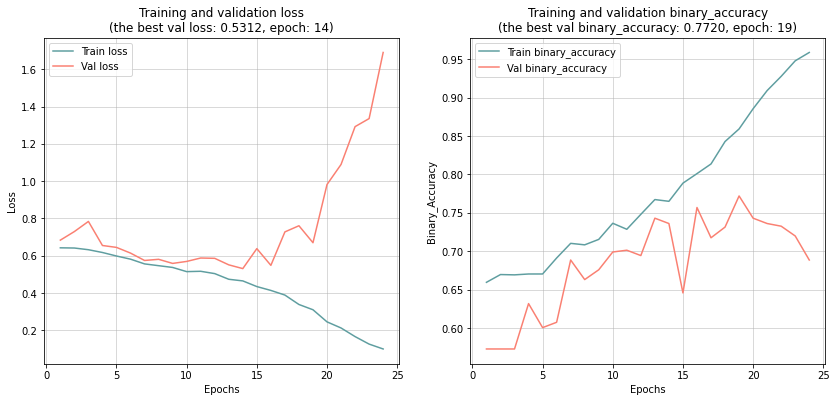

In [ ]:
# View the result
show_train_results((base_trl, base_vl), (base_trm, base_vm), metric_name=metric_name)

As we can see from the plots and training process execution data above, the minimum validation loss and maximum validation binary accuracy were achieved by the model on the 14th and 19th training epochs, respectively. And then the indicators began to deteriorate (overfitting). The CNN completely stopped its training after the 24th epoch. It can also be noted that the best loss value does not always give the best binary accuracy value and vice versa.

#### 3.2.2. Training with set weights of a positive class

Now we will train a model of the same architecture, but with the indication of the weights of the positive class ("rabbit"). Since we have half as many images of this class, its weights will be the same number of times more. All other parameters will remain unchanged.

In [ ]:
pos_class_weights = torch.tensor([2.0]).to(device)

In [ ]:
# Create a new model
model_clw = ImageClassCNN().to(device)

loss_fn_w = nn.BCEWithLogitsLoss(pos_weight=pos_class_weights)  
optimizer_clw = optim.Adam(model_clw.parameters())
save_clww_dir = os.path.join(save_weights_dir, 'model_clw')

# Train the model
clw_trl, clw_trm, clw_vl, clw_vm = fit(model_clw, train_rescale_dl, loss_fn_w, 
    optimizer_clw, save_model_weights_dir=save_clww_dir, **fit_params)

Epoch 1/50:
Train -- loss: 0.9238, binary_accuracy: 0.3900
Val -- loss: 0.9988, binary_accuracy: 0.5671
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 2/50:
Train -- loss: 0.9203, binary_accuracy: 0.4477
Val -- loss: 0.9636, binary_accuracy: 0.4931
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 3/50:
Train -- loss: 0.9122, binary_accuracy: 0.5089
Val -- loss: 0.9828, binary_accuracy: 0.4271
------------------------------------------------------------
Epoch 4/50:
Train -- loss: 0.9064, binary_accuracy: 0.4771
Val -- loss: 0.9042, binary_accuracy: 0.6562
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 5/50:
Train -- loss: 0.8506, binary_accuracy: 0.5931
Val -- loss: 0.9316, binary_accuracy: 0.6910
Saved the best

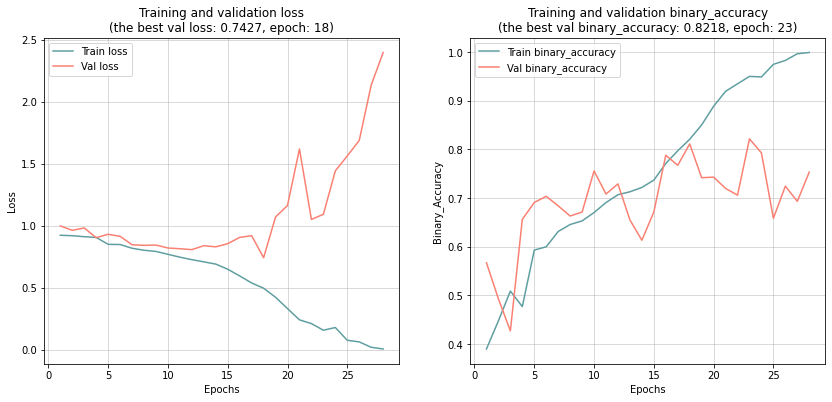

In [ ]:
# View the result
show_train_results((clw_trl, clw_vl), (clw_trm, clw_vm), metric_name=metric_name)

In this case, the best values of validation loss and binary accuracy were achieved only in the 18th and 23rd epochs, respectively, and then the overfitting began. The stopping of the training process was also started later (after the 28th epoch). In general, doubling the weights of positive class examples did not improve the performance of the model: the validation losses, which are our main metric, became quite large, although the binary accuracy on it increased.

#### 3.2.3. Training with data augmentation

As noted earlier, the available number of images we have is small, so we will perform augmentation so that our model sees "new" images every time. The rest of the training parameters will remain the same, except for the positive class weights (adding them in the previous step, in general, did not improve the model).

In PyTorch, we can set specific transformations for images yourself, or choose one of the three available auto-augmentation policies (AutoAugmentPolicy). We will use the first option.

In [ ]:
# Set add transformation parameters 
add_transforms = [ 
    T.RandomAffine(degrees=0, shear=0.2, translate=(0.2, 0.2)),
    T.RandomRotation(45),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip()]

augment_transforms = add_transforms + base_transforms[:]

# Create dataloaders with augmentation
train_augment_dl = get_dataloader(train_dir, image_transform_list=augment_transforms, 
                                  shuffle=True, batch_size=batch_size)

In [ ]:
model_aug = ImageClassCNN().to(device)

optimizer_aug = optim.Adam(model_aug.parameters())
save_augw_dir = os.path.join(save_weights_dir, 'model_aug')

aug_trl, aug_trm, aug_vl, aug_vm = fit(model_aug, train_augment_dl, loss_fn, 
    optimizer_aug, save_model_weights_dir=save_augw_dir, **fit_params)

Epoch 1/50:
Train -- loss: 0.6413, binary_accuracy: 0.6695
Val -- loss: 0.7055, binary_accuracy: 0.5729
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 2/50:
Train -- loss: 0.6377, binary_accuracy: 0.6695
Val -- loss: 0.6834, binary_accuracy: 0.5729
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 3/50:
Train -- loss: 0.6379, binary_accuracy: 0.6685
Val -- loss: 0.6875, binary_accuracy: 0.5729
------------------------------------------------------------
Epoch 4/50:
Train -- loss: 0.6357, binary_accuracy: 0.6697
Val -- loss: 0.7134, binary_accuracy: 0.5729
------------------------------------------------------------
Epoch 5/50:
Train -- loss: 0.6320, binary_accuracy: 0.6695
Val -- loss: 0.7047, binary_accuracy: 0.5729
------------------------------------------------------------
Epoch 6/50:
Train -- loss: 0.6330, binary_ac

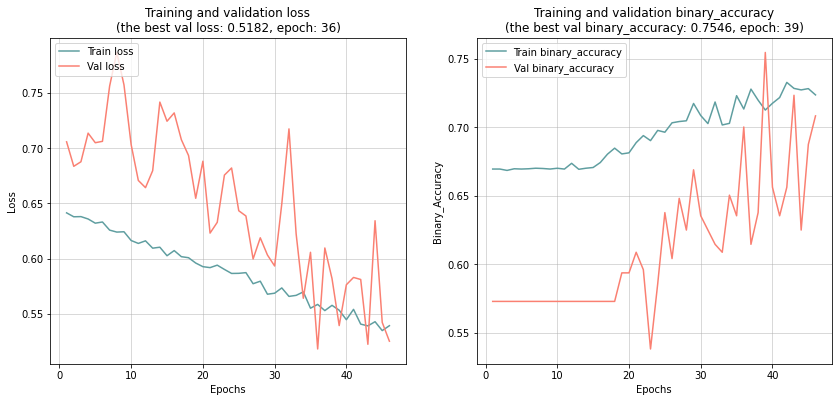

In [ ]:
# View the result
show_train_results((aug_trl, aug_vl), (aug_trm, aug_vm), metric_name=metric_name)

With augmentation, our model was trained the longest and an early stop occurred only after the 46th epoch. And at the 36th and 39th epochs, the best values of validation loss and binary accuracy were obtained, respectively. At the same time, these losses were the smallest of all those received earlier.

As a result, at the moment we are more satisfied with the training results, either with the number of images that we have initially or with augmentation. In the first case, we got a good validation binary accuracy with relatively a small loss value and the training went faster. And in the second case, we got the best verification loss, but the training took almost twice as long. **Of course, with each new start of training, there is no guarantee that these same models will remain the best.**

### 3.4. Improvement of the neural network model

We will try to improve the performance of the model with our base architecture, and we will do this in two different ways: by adding normalization and regularization layers and finding the best hyperparameter values. For training, we use the option without using positive class weights and with augmentation, because there the validation loss was lower.

#### 3.4.1. Improvement with normalization and regularization layers

We will see how the addition of normalization and regularization layers will affect the training of our CNN. To do this, we will use nn.BatchNorm2d layers and nn.Dropout layer.

In [ ]:
# Build a model class with a new architecture
class ImageClassBNormCNN(nn.Module):
    """A convolutional neural network for image classification 
    with Batch Normalization and Dropout."""
    def __init__(self):
        super().__init__()
        self.conv_bnorm_relu_maxpool = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 16, 3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.lin_relu = nn.Sequential(
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.conv_bnorm_relu_maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        out = self.lin_relu(x)
        return out

In [ ]:
model_norm = ImageClassBNormCNN().to(device)

optimizer_norm = optim.Adam(model_norm.parameters())
save_normw_dir = os.path.join(save_weights_dir, 'model_norm')

# Train the model
norm_trl, norm_trm, norm_vl, norm_vm = fit(model_norm, train_augment_dl, loss_fn, 
    optimizer_norm, save_model_weights_dir=save_normw_dir, **fit_params)

Epoch 1/50:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train -- loss: 0.6225, binary_accuracy: 0.6697
Val -- loss: 0.6371, binary_accuracy: 0.6910
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 2/50:
Train -- loss: 0.6027, binary_accuracy: 0.6785
Val -- loss: 0.5991, binary_accuracy: 0.7488
Saved the best validation binary_accuracy weights!
Saved the best validation loss weights!
------------------------------------------------------------
Epoch 3/50:
Train -- loss: 0.5816, binary_accuracy: 0.6943
Val -- loss: 0.6338, binary_accuracy: 0.6215
------------------------------------------------------------
Epoch 4/50:
Train -- loss: 0.5620, binary_accuracy: 0.7133
Val -- loss: 0.6509, binary_accuracy: 0.6620
------------------------------------------------------------
Epoch 5/50:
Train -- loss: 0.5642, binary_accuracy: 0.7065
Val -- loss: 0.5627, binary_accuracy: 0.7488
Saved the best validation loss weights!
--------------------------

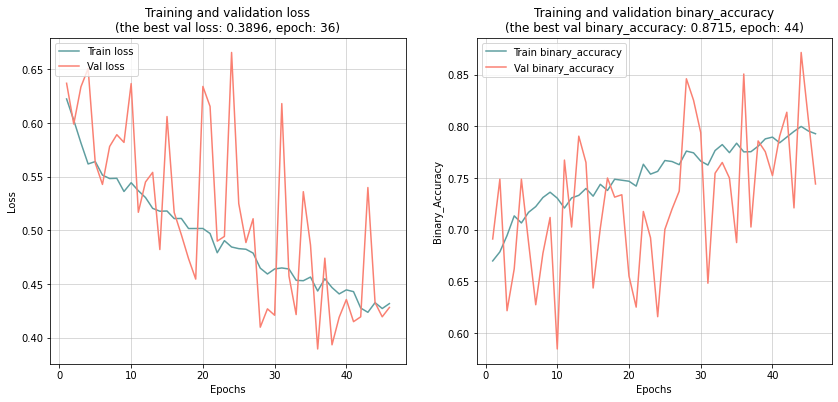

In [ ]:
# View the result
show_train_results((norm_trl, norm_vl), (norm_trm, norm_vm), metric_name=metric_name)

As we can see, adding normalization and regularization layers in the above order improved the efficiency of training, reducing the validation loss to 0.3896 and increasing its binary accuracy to 0.8715. But it still takes a lot of time to train the model.




#### 3.4.2. Search by hyperparameters with Ray Tune

To select hyperparameters using the Ray Tune, we need to perform preliminary work, namely:

1.   wrap the building of the ImageFolder subclass and getting data sets from our existing folders in a function;
2.   build a neural network model class with changing parameters (hyperparameters) that we will search for;
3. define a general training function, with which our model will be configured.

We will search only among some hyperparameters to see if there are better values for them than we currently have. As a basis, we will take the architecture of the model with layers of normalization and regularization.

In [ ]:
# Wrap getting image datasets in a function
def get_datasets(img_dir=None):
    """Returns loaded datasets."""
    class ReverseImageFolder(ImageFolder):
        """Image loader from the directory with classes in reverse alphabetical order."""
        def __init__(self, img_dir, image_transform=None):
            super().__init__(root=img_dir, transform=image_transform)
                
        def find_classes(self, directory):
            """Finds the class folders in a dataset."""
            classes = sorted((entry.name for entry in os.scandir(directory) if entry.is_dir()), reverse=True)
            if not classes:
                raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx

    img_train_dir, img_val_dir = [os.path.join(img_dir, name) for name in ['train', 'validation']]

    img_transforms = [
        T.RandomAffine(degrees=0, shear=0.2, translate=(0.2, 0.2)),
        T.RandomRotation(45),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.Resize(IMAGE_SIZE, interpolation=TF.InterpolationMode.NEAREST),
        T.ToTensor()]

    img_train_ds = ReverseImageFolder(img_train_dir,  
                                      image_transform=T.Compose(img_transforms))
    img_val_ds = ReverseImageFolder(img_val_dir,  
                                    image_transform=T.Compose(img_transforms[-2:]))
    
    return img_train_ds, img_val_ds

In [ ]:
# Make the neural network model configurable
class ImageClassTuneCNN(nn.Module):
    """A CNN with configurable hyperparameters."""
    def __init__(self, ks1=3, ks2=3, ks3=3, ks4=3, ks5=3, stride1=2, stride2=2, 
                 stride3=2, stride4=3, dp=0.2, out_lin1=32, activ_func=nn.ReLU):
        super().__init__()
        self.conv_bnorm_relu_maxpool = nn.Sequential(
            nn.Conv2d(3, 8, ks1, padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride1),
            nn.Conv2d(8, 16, ks2, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride2),
            nn.Conv2d(16, 32, ks3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride3),
            nn.Conv2d(32, 64, ks4, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, ks5, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride4),
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dp)
        self.lin_relu = nn.Sequential(
            nn.LazyLinear(out_lin1), 
            activ_func(),
            nn.Linear(out_lin1, 1),
        )

    def forward(self, x):
        x = self.conv_bnorm_relu_maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        out = self.lin_relu(x)
        return out

In [ ]:
# Defining the general training function
def train_tune_model(config, checkpoint_dir=None, img_dir=None, metric_fn=None):
    """Wraps the training of a model to configure it."""
    img_train_ds, img_val_ds = get_datasets(img_dir)
    train_dataloader = DataLoader(img_train_ds, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(img_val_ds, batch_size=32)

    tune_model = ImageClassTuneCNN(
        config['ks1'], 
        config['ks2'], 
        config['ks3'], 
        config['ks4'], 
        config['ks5'], 
        config['stride1'], 
        config['stride2'], 
        config['stride3'], 
        config['stride4'],
        config['dp'], 
        config['out_lin1'], 
        config['activ_func'])
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tune_model = tune_model.to(device)
   
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(tune_model.parameters())
    
    step = 0
    # Load states from a checkpoint
    if checkpoint_dir:
        checkpoint_path = os.path.join(checkpoint_dir, 'ray_tune_checkpoint')
        tune_checkpoint = torch.load(checkpoint_path)
        tune_model.load_state_dict(tune_checkpoint['model_state_dict'])
        optimizer.load_state_dict(tune_checkpoint['optimizer_state_dict'])
        step = tune_checkpoint['step'] + 1  

    for epoch in range(50):

        # Train a neural network model
        _ = train_model(tune_model, train_dataloader, loss_fn, optimizer, 
                        metric_fn, device)
        
        # Evaluate the trained model
        val_loss, val_metric = evaluate_model(tune_model, val_dataloader, loss_fn, 
                                              metric_fn, device)
        
        # Create a checkpoint
        with tune.checkpoint_dir(step=step) as checkpoint_dir:
            checkpoint_path = os.path.join(checkpoint_dir, 'ray_tune_checkpoint')
            torch.save({
                'model_state_dict': tune_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'step': step,
            }, checkpoint_path)

        tune_report_params = {'val_loss': val_loss}
        if metric_fn:
            val_metric_name = '_'.join(['val', metric_fn.__name__])
            tune_report_params[val_metric_name] = val_metric

        # Log all keyword arguments to control the tuning process 
        tune.report(**tune_report_params)

We will write down among which values we want to perform this search.

In [ ]:
val_metric_name = '_'.join(['val', metric_name])

# Define a search space for the hyperparameters
search_space = {
    'ks1': tune.choice([3, 5]),
    'ks2': tune.choice([3, 5]), 
    'ks3': tune.choice([3, 5]), 
    'ks4': tune.choice([3, 5]), 
    'ks5': tune.choice([3, 5]),
    'stride1': tune.randint(1, 4), 
    'stride2': tune.randint(1, 4), 
    'stride3': tune.randint(1, 4),  
    'stride4': tune.randint(1, 3), 
    'dp': tune.quniform(0.0, 0.5, 0.1), 
    'out_lin1': tune.sample_from(lambda _: 2**np.random.randint(5, 8)), 
    'activ_func': tune.choice([nn.ReLU, nn.SELU, nn.ELU]),
    } 

reporter = JupyterNotebookReporter(True)

Now we will start tuning, which will select 5 combinations of configurable parameters. We can also, if desired, define a search algorithm or schedulers. We will use the ones that are set by default, i.e. Random search and FIFO  scheduler. Then we will choose the two best configurations from the results obtained: with a lower value of validation loss and a higher value of validation binary accuracy. Theoretically, with fewer losses, the binary accuracy should be higher, but, as we noted earlier, in practice this is not always the case. 

We will look for only 45 iterations, because the model that we took as a basis showed the best results from all the previous epochs up to this number. Additionally, as a stopping criterion, we will also indicate the loss values of 1.0. As we saw earlier, after reaching this value, the models only get worse, which means there is no point in training them further.

In [ ]:
analysis = tune.run(
    tune.with_parameters(train_tune_model, img_dir=image_store_dir, 
                         metric_fn=metric_fn),
    config=search_space,
    num_samples=5,
    stop={'training_iteration': 45, 'val_loss': 1.0},
    local_dir=project_dir,
    name='Ray_Tune_results',
    progress_reporter=reporter,
    resources_per_trial={'gpu': 1},
    resume=True)

Trial name,status,loc,activ_func,dp,ks1,ks2,ks3,ks4,ks5,out_lin1,stride1,stride2,stride3,stride4,iter,total time (s),val_loss,val_binary_accuracy
train_tune_model_2fad4_00004,TERMINATED,,<class 'torch.nn.modules.activation.SELU'>,0.4,5,5,3,3,3,64,3,1,1,2,45,3049.17,0.695157,0.572917
train_tune_model_2fad4_00002,TERMINATED,,<class 'torch.nn.modules.activation.ELU'>,0.3,3,3,5,5,3,32,1,2,2,1,45,3118.84,0.703998,0.572917
train_tune_model_2fad4_00003,TERMINATED,,<class 'torch.nn.modules.activation.SELU'>,0.1,5,5,3,3,3,32,3,2,1,2,7,465.381,1.03528,0.380787
train_tune_model_2fad4_00001,TERMINATED,,<class 'torch.nn.modules.activation.ELU'>,0.2,3,5,5,3,5,64,1,3,1,1,45,3202.77,0.687809,0.572917
train_tune_model_2fad4_00000,TERMINATED,,<class 'torch.nn.modules.activation.ReLU'>,0.1,3,5,5,3,3,64,1,2,3,1,45,3116.44,0.639593,0.638889


2021-07-10 15:08:04,954	INFO tune.py:549 -- Total run time: 0.94 seconds (0.00 seconds for the tuning loop).


***Note:***  *the time indicated at the bottom of the cell output shows the resume time from a checkpoint, since the training was run in another notebook and took 9491.04 seconds (about 2 hours 38 minutes)*

Here we can see which values of the monitored metrics we received in the last training epoch and which configurations were selected by the search algorithm. It can also be noted that only one of the five models under consideration was stopped earlier than the others, at the 7th iteration, having reached the loss value we determined earlier.

Next, we will look at each metric, whether the last values are the best among all.

In [ ]:
# Look at the best values of validation loss among all training epochs
analysis_best_loss_df = analysis.dataframe(metric='val_loss', mode='min')

(analysis_best_loss_df.loc[:, ['val_loss', val_metric_name, 'training_iteration']]
                      .join(analysis_best_loss_df.loc[:, 'config/activ_func':'config/stride4'])
                      .nsmallest(1, 'val_loss', keep='all'))

,val_loss,val_binary_accuracy,training_iteration,config/activ_func,config/dp,config/ks1,config/ks2,config/ks3,config/ks4,config/ks5,config/out_lin1,config/stride1,config/stride2,config/stride3,config/stride4
4,0.531139,0.744213,32,<class 'torch.nn.modules.activation.ReLU'>,0.1,3,5,5,3,3,64,1,2,3,1


In [ ]:
# Look at the best values of validation binary accuracy among all training epochs
analysis_best_ba_df = analysis.dataframe(metric=val_metric_name, mode='max')

(analysis_best_ba_df.loc[:, ['val_loss', val_metric_name, 'training_iteration']]
                    .join(analysis_best_ba_df.loc[:, 'config/activ_func':'config/stride4'])
                    .nlargest(1, val_metric_name, keep='all'))

,val_loss,val_binary_accuracy,training_iteration,config/activ_func,config/dp,config/ks1,config/ks2,config/ks3,config/ks4,config/ks5,config/out_lin1,config/stride1,config/stride2,config/stride3,config/stride4
4,0.535301,0.767361,42,<class 'torch.nn.modules.activation.ReLU'>,0.1,3,5,5,3,3,64,1,2,3,1


As we can see, the configurations found with the best values of validation loss and binary accuracy are identical in our case. Only the epoch in which they were achieved differs. We can also get the corresponding trials.

In [ ]:
# Get and view a trial with the best validation loss
best_loss_trial = analysis.get_best_trial('val_loss', 'min', 'all') 
print("The best config: ")
for k, v in best_loss_trial.config.items():
    print(k, ": ", v)
print("The best validation loss: ", analysis_best_loss_df['val_loss'].min()) 

The best config: 
ks1 :  3
ks2 :  5
ks3 :  5
ks4 :  3
ks5 :  3
stride1 :  1
stride2 :  2
stride3 :  3
stride4 :  1
dp :  0.1
out_lin1 :  64
activ_func :  <class 'torch.nn.modules.activation.ReLU'>
The best validation loss:  0.5311394631862639


In [ ]:
# Get and view a trial with the best validation binary accuracy
best_ba_trial = analysis.get_best_trial(val_metric_name, 'max', 'all') 
print("The best config: ")
for k, v in best_ba_trial.config.items():
    print(k, ": ", v)
print(f"The best validation {metric_name}: ", analysis_best_ba_df[val_metric_name].max()) 

The best config: 
ks1 :  3
ks2 :  5
ks3 :  5
ks4 :  3
ks5 :  3
stride1 :  1
stride2 :  2
stride3 :  3
stride4 :  1
dp :  0.1
out_lin1 :  64
activ_func :  <class 'torch.nn.modules.activation.ReLU'>
The best validation binary_accuracy:  0.7673611044883728


Next, we will create an instance of the model and load a state dictionary from the checkpoint with the best found configuration into it. To do this, we use the last checkpoint in our case, because we made saves at each iteration, but the indicators in it are certainly worse. If we need to continue training the found model, we can also restore the checkpoint.

In [ ]:
# Restore a model from a checkpoint with the best config
best_tune_model = ImageClassTuneCNN(
    best_loss_trial.config['ks1'], 
    best_loss_trial.config['ks2'], 
    best_loss_trial.config['ks3'], 
    best_loss_trial.config['ks4'], 
    best_loss_trial.config['ks5'], 
    best_loss_trial.config['stride1'], 
    best_loss_trial.config['stride2'], 
    best_loss_trial.config['stride3'], 
    best_loss_trial.config['stride4'], 
    best_loss_trial.config['dp'], 
    best_loss_trial.config['out_lin1'], 
    best_loss_trial.config['activ_func'])
best_tune_model = best_tune_model.to(device)

best_tune_ckpt_path = os.path.join(best_loss_trial.checkpoint.value, 'ray_tune_checkpoint')
best_tune_checkpoint = torch.load(best_tune_ckpt_path)
best_tune_model.load_state_dict(best_tune_checkpoint['model_state_dict'])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

### 3.5. Evaluating models on the test dataset

At the end of this section, we will evaluate the three models: the one that we found by searching for hyperparameters, and two with loaded weights with the best indicators on the test image dataset.

To do this, we will create a DataLoader for the dataset used and two instances of the model with the normalization and regularization layers to load state dictionaries with the best val_loss and val_binary_accuracy values into them.

In [ ]:
# Create a test dataloader with base transformation
test_dl = get_dataloader(test_dir, image_transform_list=base_transforms, 
                         shuffle=False, batch_size=batch_size)

In [ ]:
# Specify the path where the best state dictionaries are stored
load_loss_weights_dir = os.path.join(save_weights_dir, 'model_norm/best_loss_weights.pt')
load_ba_weights_dir = os.path.join(save_weights_dir, f'model_norm/best_{metric_name}_weights.pt')

In [ ]:
best_loss_norm_model = ImageClassBNormCNN().to(device)
best_ba_norm_model = ImageClassBNormCNN().to(device)

# Load a model state with the best val_loss and val_binary_accuracy
best_loss_norm_model.load_state_dict(torch.load(load_loss_weights_dir))
best_ba_norm_model.load_state_dict(torch.load(load_ba_weights_dir))

<All keys matched successfully>

In [ ]:
# Evaluate the loaded model with the best val_loss state dictionary
_ = evaluate_model(best_loss_norm_model, test_dl, loss_fn, metric_fn, device)

Val -- loss: 0.5838, binary_accuracy: 0.7031


In [ ]:
# Evaluate the loaded model with the best val_binary_accuracy state dictionary
_ = evaluate_model(best_ba_norm_model, test_dl, loss_fn, metric_fn, device)

Val -- loss: 0.6060, binary_accuracy: 0.6667


In [ ]:
# Evaluate the tune_model with the best value of metrics
_ = evaluate_model(best_tune_model, test_dl, loss_fn, metric_fn, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Val -- loss: 0.6598, binary_accuracy: 0.6146


The first version of the models, which is based on a dictionary of states with the best validation loss, as expected, gave the best result. 

## 4. Training a model using transfer learning


All the pre-trained models in PyTorch expect that input images will be RGB with 3 channels of the shape (3 x H x W), where H and W are a height and width, which must be at least 224. The images must also have a range of [0, 1]and be normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Therefore, before we start implementing transfer learning directly,  we will create datasets and dataloaders with these specified transformations.

In [ ]:
# Create a list of necessary preliminary image transformations
pre_transforms = [
        T.Resize((224, 224), interpolation=interp_mode),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])]

In [ ]:
# Set common parameters for all dataloaders
imgdl_params = dict(
    image_transform_list=pre_transforms,
    batch_size=batch_size)

In [ ]:
# Create dataloaders
train_prem_dl = get_dataloader(train_dir, shuffle=True, **imgdl_params)
val_prem_dl = get_dataloader(val_dir, shuffle=False, **imgdl_params)
test_prem_dl = get_dataloader(test_dir, shuffle=False, **imgdl_params)

There are various ways to use pre-trained models for transfer learning. We, in turn, implement one of them, namely: we use a pre-trained model to extract features, and build a classifier on top of it, which we will train. And then we will fine-tune it.

The pre-trained model we can find in TORCHVISION.MODELS. Let's take, for example, Wide ResNet-50-2 and import it. Information about this network can be found at: ["Wide Residual Networks"](https://arxiv.org/pdf/1605.07146.pdf).

Now we will create an instance of this model with pre-trained weights on the ImageNet.

In [ ]:
pretrain_model = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


In [ ]:
# Look at the architecture of the loaded model
print(pretrain_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Note that the Wide ResNet-50-2 model contains BatchNorm2d layers, this will be important when implementing fine-tuning.

To use parameters of the pre-trained model and not change them during training of a new model, all layers must be frozen.

In [ ]:
# Freeze the pre-trained model
for param in pretrain_model.parameters():
    param.requires_grad = False

Instead of the top pooling and linear layers of the pre-trained model, in the new model we will use several top layers of our base model created earlier.

In [ ]:
# Create a deep copy of the pre-trained model, so as not to change it
new_model = copy.deepcopy(pretrain_model)

# Create a classifier with new layers
new_model.avgpool = nn.Sequential( 
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(18432, 32), 
    nn.ReLU(),
)

new_model.fc = nn.Linear(32, 1)

new_model = new_model.to(device)

To continue using the resulting new model, we need to train new layers.  In order not to change the parameter values in the BatchNorm2d layers, we have included in the training function, which we defined earlier, the ability to set these layers to the evaluation mode (train_batch_norm_dropout_layers=False). We will also set the number of epochs to 20, since our base model showed the best results before this number of epochs.

In [ ]:
# Set common parameters for model training
fit_prem_params = dict(
    train_dataloader=train_prem_dl,
    val_dataloader=val_prem_dl,
    metric_fn=metric_fn,
    loss_fn=loss_fn,
    epochs=20, 
    device=device,
    train_batch_norm_dropout_layers=False,
    num_epochs_wait_early_stopping=5)

In [ ]:
# Initialize an optimizer
optimizer_prem = optim.Adam(new_model.parameters()) 

# Train the classifier with new layers
_ = fit(new_model, optimizer=optimizer_prem, **fit_prem_params)

Epoch 1/20:
Train -- loss: 0.2372, binary_accuracy: 0.9298
Val -- loss: 0.0906, binary_accuracy: 0.9688
------------------------------------------------------------
Epoch 2/20:
Train -- loss: 0.0548, binary_accuracy: 0.9779
Val -- loss: 0.0769, binary_accuracy: 0.9711
------------------------------------------------------------
Epoch 3/20:
Train -- loss: 0.0167, binary_accuracy: 0.9950
Val -- loss: 0.0282, binary_accuracy: 0.9896
------------------------------------------------------------
Epoch 4/20:
Train -- loss: 0.0084, binary_accuracy: 0.9979
Val -- loss: 0.0229, binary_accuracy: 0.9896
------------------------------------------------------------
Epoch 5/20:
Train -- loss: 0.0046, binary_accuracy: 0.9992
Val -- loss: 0.0340, binary_accuracy: 0.9896
------------------------------------------------------------
Epoch 6/20:
Train -- loss: 0.0016, binary_accuracy: 1.0000
Val -- loss: 0.0407, binary_accuracy: 0.9896
------------------------------------------------------------
Epoch 7/20

At the moment, the best loss and binary accuracy in the validation dataset are 0.0201 and 0.9896, respectively. But now we can fine-tune it by starting the training process again, unfreezing all the layers before doing so, and setting the learning rate very low to prevent overfitting.

In [ ]:
# Unfreeze the pre-trained model
for param in new_model.parameters():
    param.requires_grad = True

In [ ]:
optimizer_ft = optim.Adam(new_model.parameters(), lr=1e-5) 

# Perform fine-tuning of the model
_ = fit(new_model, optimizer=optimizer_ft, **fit_prem_params)

Epoch 1/20:
Train -- loss: 0.0103, binary_accuracy: 0.9970
Val -- loss: 0.0128, binary_accuracy: 1.0000
------------------------------------------------------------
Epoch 2/20:
Train -- loss: 0.0166, binary_accuracy: 0.9950
Val -- loss: 0.3281, binary_accuracy: 0.9711
------------------------------------------------------------
Epoch 3/20:
Train -- loss: 0.0143, binary_accuracy: 0.9943
Val -- loss: 0.0138, binary_accuracy: 0.9815
------------------------------------------------------------
Epoch 4/20:
Train -- loss: 0.0048, binary_accuracy: 0.9985
Val -- loss: 0.0300, binary_accuracy: 0.9815
------------------------------------------------------------
Epoch 5/20:
Train -- loss: 0.0049, binary_accuracy: 0.9989
Val -- loss: 0.1691, binary_accuracy: 0.9896
------------------------------------------------------------
Epoch 6/20:
Train -- loss: 0.0005, binary_accuracy: 1.0000
Val -- loss: 0.0332, binary_accuracy: 0.9896
Early Stopping!


As we can see, in our case, the val_binary_accuracy remains generally the same as at the end of the previous training, except for the first epoch, in which val_loss is also better. If we compare in general the results of our previously trained models and transfer learning, it is obvious that the latter has better ones.

At the end, we will evaluate our new model on the test data.

In [ ]:
# Evaluate the new model
_ = evaluate_model(new_model, test_prem_dl, loss_fn, metric_fn, device)

Val -- loss: 0.0032, binary_accuracy: 1.0000


And as expected, we also got improved performance on previously unseen images. Moreover, the validation loss values are less, and the validation binary accuracy is higher than that of all previously trained models in this notebook.